In [3]:
import pandas as pd
import numpy as np
import openai
import json
from tqdm import tqdm
import ast
import plotly.express as px
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns
# import math
# import PyPDF2
import os
import re
import google.generativeai as genai
import signal
import shutil

In [ ]:
genai.configure(api_key="your api key") # Replace with your actual API key

In [ ]:
# configure which version of Gemini to use
model_2_5_flash = genai.GenerativeModel('gemini-2.5-flash')
# check that this is the model of Gemini that you want to use!

The below question is specifically tailored to the papers on PID related stories. This can be used as a template for other types of degradation, or you can replace with a completely different question

In [ ]:
question = """Please read the provided paper and extract the following information. Ensure that all extracted information is concise, specific, and directly reflects the content of the paper without adding any external information. Only return this dictionary to me and don’t provide other context. You can first review the “abstract,” “introduction,” and “conclusion” sections to get some high level answers. Extract specific content from the other sections of the paper. 

Degradation mechanism chains should be listed in clear steps. For example, after reading a paper you may find the mechanism chain to be “[negative voltage bias] -> [sodium ion migration from glass] -> [formation of local shunts] -> [power output decrease].” These mechanisms need to be listed as a clear chain of events. Be sure to list only how the material degrades. Tell me “what” steps cause “what” type of degradation. If there are multiple paths and/or multiple mechanisms, list them as two separate chains. 

As you read the paper, extract as much specific information as possible. For example, after reading the paper, you may get a degradation mechanism like “Diffusion of copper from the contact, facilitated by the degraded EVA encapsulant”. However, “degraded EVA encapsulant” is vague. Now go to the other sections of this paper and find out what is this EVA degradation. After reviewing other parts, you can get a new detailed answer like: “Moisture ingress causes EVA to produce acetic acid, which corrodes the copper plating, allowing copper to diffuse into the silicon”. Note that phrases like “”material degradation” are not good. You need to tell me “what” material and “”what” degradation mechanism by reading the whole paper.

These papers are specific to Potential Induced Degradation (PID). Please find what type of PID the paper reviews, or indicate if multiple are present. They are abbreviated as follows: shunting (PID-s); polarization (PID-p); corrosion (PID-c). Note that the “abstract” and “introduction” may discuss PID types that are not studied in this paper, so be sure to read for which is studied in this paper.

Provide the information in the following dictionary format:
{
year: [year of paper publication],
module name: [indicate the pv module name. This should indicate a manufacturer or other fabrication source, and if those are not available, choose ‘not reported’. Standardize terminology to create categories. For example, “industrial bifacial PERC solar cell” and “industrially produced bifacial PERC+ solar cell” should both be put under the category “industrial PERC solar cell”. Other examples would be “TOPCon PV modules” or “custom minimodules”. Specifications such as ‘(A-E)’ in ‘custom minimodules (A-E)’ should be omitted, leaving just the main component - in this example, ‘custom minimodules’.],
module component materials: [report the other materials listed as module components. This can include antireflective coatings, frames, encapsulants, etc. Note that this should ONLY include materials used in the module tested in this study, not materials discussed but not tested. These are primarily found in the “Materials”, “Methods”, or “Experimentatal” sections. ],
module power: [in format of ‘xx W’. If the power of the tested module is not directly listed in the paper, state “not reported”.],
irradiance: [in the format of ‘xxxx W/m2’ OR ‘AM xx.xx G’. Note that “standard spectral irradiance” refers to 1000 W/m2, which is equal to AM1.5G]
voltage bias: [in the format of ‘-xxxx V’ for negative bias or ‘+xxxx V’ for positive bias]
temperature: [the temperature or temperatures at which measurements were taken. May be formatted as a list ‘X C, Y C, Z C’ or a range if measurements were continuously taken ‘25 C-85 C’. Note that C indicates degrees Celsius. ]
humidity: [humidity reported for either laboratory or ambient conditions, formatted as ‘xx%’]
module technology: [choose from ‘mono-c-Si’, ‘multi-c-Si’,‘a-Si’, ‘CdTe’, ‘CIGS’, ‘thin film’, ‘HIT’, ‘other’, ‘not reported’; if paper reports it as ‘poly-c-Si’, ‘mc-Si’, ‘multicrystalline silicon’, ‘multicrystalline Si’, or ‘polycrystalline silicon’, it refers to ‘multi-c-Si’. If a paper reports ‘c-Si’, 'crystalline silicon', ‘monocrystalline silicon’, ‘monocrystalline Si’, or ‘single crystal silicon’ refers to ‘mono-c-Si’’. Do NOT include an indication of doping in this category, as that will be the next part of the dictionary.],
doping: [choose from ‘p-type’, ‘n-type’, ‘not reported’. If the paper reports it as ‘p-Si’, ‘n-Si’, or ‘p-doped silicon’ it refers to ‘p-type’. If the paper reports it as ‘n-Si’, ‘n-doped silicon’ it refers to ‘n-type’.],
bifacial:[whether the PV module is bifacial, listed as ‘bifacial’ or ‘monofacial’, ‘not reported’], 
mounting:[mounting location of PV modules. Choose from “roof”, “rack”, “tracker”, “outdoor test”, “indoor laboratory”, or “not reported”],
PID type studied: [choose from ‘PID-s’, ‘PID-p’, ‘PID-c’, or ‘not specified’. You may list more than one. ‘Na-penetration-type PID’ is ‘PID-c’. ]

challenge: [Describe the main issue or problem of the specific module material and degradation mode in the paper. Be specific about how the PV modules are affected by this issue. Do not just state the issue. For example, “PID in solar module” is not a good summary but “PID-s in silicon cell lowers parallel resistance and decreases power output. Degradation accelerated by moisture and heat” is a good summary. As another example, “differences in test conditions” is not specific about the measurement issue, but “Difference in measuring at standard test conditions vs. stress temperatures” is better.],

degradation mechanism chain: [Identify the sequential causes or factors that lead to the
degradation occurring, listed in order. Include specific chemical reactions or physical changes.
Each factor in the chain should trigger the next. Be accurate and concise about the cause.
For example,
“extended damp heat stress” is not a good chain element since this is the name of
the accelerated testing. Instead “moisture ingression” is the true factor that causes the
degradation during the damp heat test. Don’t use vague content. For example “silicon cell
degradation” is vague because the type of degradation is not specified. Instead,
“local shunt
formation in silicon cells” is good because it specifies what degradation happens where.
‘Not
reported’ is not an option for this part of the dictionary.],

mitigation strategy: [List any proposed solutions or strategies to mitigate the challenge. This part of the paper is most often found in the “conclusion” section. This may include proposals to prevent PID or ways to observe and predict the degradation. For example, a good mitigation strategy summary is “predict resistance to PID through correlation between shunts and physical defects.” If no strategic solution to the challenge is mentioned, put N/A],

summary: [Provide a concise summary combining the challenge, trigger, and degradation mechanism, explaining how the initial cause leads to the identified challenge and mentioning the mitigation strategy if available. Be sure to include the key experimental parameters outlined.]
}

If there is a chain of triggers, put them into a list. For example, “Moisture ingress causes EVA to hydrolyze, producing acetic acid, which corrodes the copper contacts. This corrosion facilitates the diffusion of copper into the silicon cell, where it accumulates in the space-charge region, deteriorating diode parameters and increasing series resistance” yield a chain like this: [moisture ingression] -> [acetic acid from EVA hydrolyzation] -> [copper corrosion and diffusion] -> [Copper accumulated at space-charge region and increase series resistance]

If two triggers parallelly lead to the next one, then put these two together. For example “UV exposure” and “loss of UV absorber” both lead to “deacetylations”, then put this like [[“UV exposure”, “loss of UV absorber”], “deacetylations”]. Don’t put it like [“UV exposure”, “loss of UV absorber”, “deacetylations”] because UV exposure doesn’t lead to loss of UV absorber.

If multiple cases are reported, return a list of dicts.

Here is an example dict:
[{
“year”: 2020,
module name: [custom minimodules.],
module component materials: [aluminum frame, EVA encapsulant],
module power: [20 W],
irradiance: [1000 W/m2]
voltage bias: [-1000 V]
temperature: [25 C]
humidity: [70%]
module technology: [multi-c-Si],
doping: [p-type],
bifacial: [monofacial], 
Mounting: [indoor laboratory],
PID type studied: [PID-s, PID-c]


"challenge": "PA-based backsheet cracking",
 "degradation mechanism chain": [
    "ultraviolet radiation",
    "EVA hydrolyzation producing acetic acid",
    "Acetic acid embrittles PA-based backsheet by chemi-crystallization"
  ],
 "mitigation strategy": "N/A",
 "summary": "Acetic acid, as a by-product of EVA photodegradation, embrittles the inner layer of PA-based backsheet by chemi-crystallization, making the backsheet prone to fracture under thermomechanical stress."
 }]

Here is another example with strategy:
[{
“year”: 2017,
module name: [TOPCon Solar Cells],
module component materials: [EVA encapsulant],
module power: [10 W],
irradiance: [900 W/m2]
voltage bias: [+800 V]
temperature: [20 C-80 C]
humidity: [85%]
module technology: [mono-c-Si],
doping: [n-type]
bifacial: [bifacial], 
Mounting: [outdoor experiment],
PID type studied: [PID-s]


"challenge": "Expensive and long duration testing methods", “Differences in theoretical values vs real measurements” 
 "degradation mechanism chain": [
    "heat", “humidity”, “voltage bias”
    "Movement of ions across panel",
    "Reduced power output"
  ],
 "mitigation strategy": "Maximum-power temperature translation method that uses near-linear relationship between mismatch and power degradation. Reduces test duration and costs. Works from any stress temperature down to 25C. Error compensation method can be applied to PID field studies, avoiding the need to dismount the module from a field array",
 "summary": "Heat, humidity, and voltage bias all stress the solar module. Measuring across a number of temperatures validates the method of translating between power output values at different temperatures and irradiances."
}]

}]

"""

In [ ]:
num_pdfs = len([f for f in os.listdir("PID_run_all") if f.endswith('.pdf')])
print(f"Number of PDF files: {num_pdfs}") # check the number of PDFs that have successfully downloaded & will be read

Number of PDF files: 58


In [21]:
pdf_files = [os.path.splitext(f)[0] for f in os.listdir("PID_run_all") if f.endswith('.pdf')]
pdf_files = sorted(pdf_files)
os.makedirs("json_allPID", exist_ok=True) #create json output folder

Load PDFs for reading & set output

In [22]:
def handler(signum, frame):
    raise TimeoutError

pdf_folder = "PID_run_all"
failed_folder = "PID_run_all_failed"
os.makedirs(failed_folder, exist_ok=True)
min_size_bytes = 1024  # 1 KB minimum size to consider the file valid

# Iterate over selected PDF files
for paper_title in tqdm(pdf_files, desc="Processing papers"):

    pdf_path = os.path.join(pdf_folder, f"{paper_title}.pdf")

    # Skip empty/damaged files
    if not os.path.exists(pdf_path):
        print(f"{paper_title} skipped: file not found.")
        continue

    if os.path.getsize(pdf_path) < min_size_bytes:
        print(f"{paper_title} skipped: file too small or empty.")
        shutil.move(pdf_path, os.path.join(failed_folder, f"{paper_title}.pdf"))
        continue

    try:
        # Optional: try opening PDF to make sure it has pages (using PyMuPDF / fitz)
        import fitz
        doc = fitz.open(pdf_path)
        if doc.page_count == 0:
            raise ValueError("PDF has no pages.")
        doc.close()

        # Set a timeout of 15 seconds for upload
        signal.signal(signal.SIGALRM, handler)
        signal.alarm(15)

        myfile = genai.upload_file(pdf_path)

        # Disable alarm after successful upload
        signal.alarm(0)

        model = genai.GenerativeModel("gemini-2.5-flash")
        result = model.generate_content(
            [question, "\n\n", myfile],
            generation_config={"temperature": 0} # Set temperature to 0 for deterministic output
        )

        res_text = result.text

        match = re.search(r'```json\n([\s\S]+?)\n```', res_text)
        if match:
            json_data = json.loads(match.group(1))
            output_file = f"json_allPID/gemini_{paper_title}.json"
            with open(output_file, "w") as file:
                json.dump(json_data, file, indent=4)

    except TimeoutError:
        print(f'{paper_title} failed due to upload timeout')
        shutil.move(pdf_path, os.path.join(failed_folder, f"{paper_title}.pdf"))
        continue

    except Exception as e:
        print(f'{paper_title} failed due to: {e}')
        shutil.move(pdf_path, os.path.join(failed_folder, f"{paper_title}.pdf"))
        continue

Processing papers: 100%|██████████| 58/58 [27:21<00:00, 28.30s/it]


In [23]:
json_data

{'year': 2025,
 'module name': 'TOPCon PV modules',
 'module component materials': ['soda lime glass',
  'EVA encapsulant',
  'zero-halogen flux'],
 'module power': 'not reported',
 'irradiance': '800 W/m2',
 'voltage bias': '-1500 V',
 'temperature': ['60 C', '75 C', '85 C', '95 C'],
 'humidity': ['55%', '75%', '80%', '100%'],
 'module technology': 'mono-c-Si',
 'doping': 'n-type',
 'bifacial': 'bifacial',
 'mounting': ['indoor laboratory', 'outdoor test', 'roof', 'rack'],
 'PID type studied': ['PID-s', 'PID-p', 'PID-c'],
 'challenge': 'Potential induced degradation (PID) in TOPCon PV modules leads to substantial performance losses, especially under high system voltage, humidity, and temperature. Current accelerated test methods are insufficient for predicting long-term field degradation under real operating conditions, including illumination.',
 'degradation mechanism chain': [['negative voltage bias'],
  ['positive charge accumulation in front surface passivation/anti-reflection (AR

# graph results - distributions of dictionary categores

In [3]:
# set colors for graphs
colors = ['#87CEEB', "#FF9A9A", "#FFEC99", "#E7A5FF", "#B2F7BE", "#95B7FF", "#966fdf", "#ffb3e6", "#ffcc99", "#c2f0c2", "#d9d9d9", "#ff6666", "#66b3ff", "#99ff99", "#ffcc00"]
colors_mono = ['#87CEEB', "#579DB9", "#2C6F8A", "#224350", "#B5E7FB", "#E3F7FF", "#021922", "#000000",]
colors_mono2 = ["#FFc7d3", "#eaa4b3", "#d28394", "#b36375", "#FFc7d3", "#a8475c", "#672937", "#7e293c",]
colors_mono3 = ["#FFE2D4", "#E1B18F", "#CE8F5C", "#BD7439", "#975C19", "#6F3B0A", "#4B2300", "#000000",]
colors_mono4 = ["#D6FFCE", "#AFFB7C", "#79D64D", "#4DA636", "#1B9719", "#0A6F17", "#004B13", "#083602",]

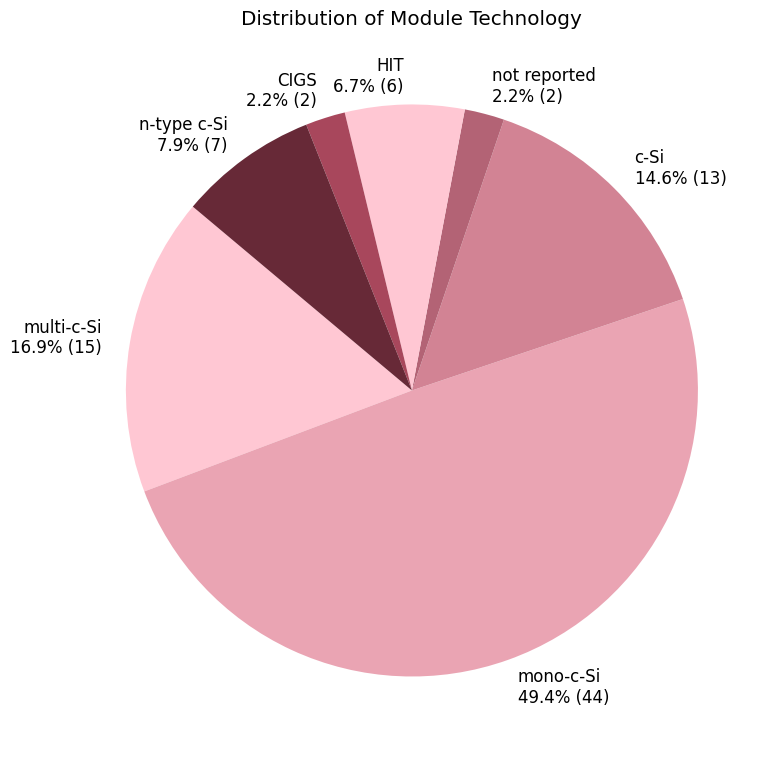

In [21]:
import os
import json
from collections import Counter

import matplotlib.pyplot as plt

json_dir = "json_allPID"
module_techs = []

for fname in os.listdir(json_dir):
    if fname.endswith(".json"):
        with open(os.path.join(json_dir, fname), "r") as f:
            data = json.load(f)
            # Handle both dict and list of dicts
            if isinstance(data, dict):
                module_techs.append(data.get("module technology", "not reported"))
            elif isinstance(data, list):
                for entry in data:
                    module_techs.append(entry.get("module technology", "not reported"))

# Flatten module_techs so only strings are counted
flat_module_techs = []
for tech in module_techs:
    if isinstance(tech, list):
        flat_module_techs.extend(tech)
    else:
        flat_module_techs.append(tech)
counts = Counter(flat_module_techs)
labels = []
sizes = []
for tech, count in counts.items():
    percent = 100 * count / sum(counts.values())
    labels.append(f"{tech}\n{percent:.1f}% ({count})")
    sizes.append(count)

plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct=None, startangle=140, colors=colors_mono2)
plt.title("Distribution of Module Technology")
plt.rcParams.update({'font.size': 12})
plt.tight_layout()
plt.show()

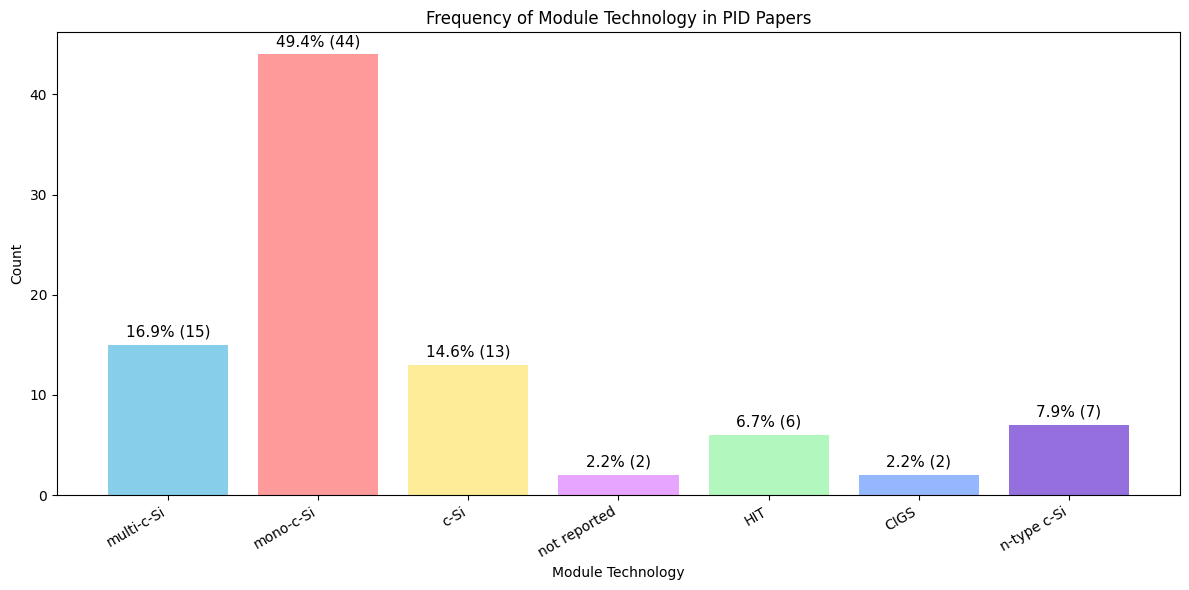

In [4]:
import os
import json
from collections import Counter

import matplotlib.pyplot as plt

json_dir = "json_allPID"
module_techs = []

# Collect all module technology entries from all JSON files
for fname in os.listdir(json_dir):
    if fname.endswith(".json"):
        with open(os.path.join(json_dir, fname), "r") as f:
            data = json.load(f)
            entries = data if isinstance(data, list) else [data]
            for entry in entries:
                techs = entry.get("module technology", "not reported")
                if isinstance(techs, list):
                    module_techs.extend(techs)
                else:
                    module_techs.append(techs)

# Count occurrences
counts = Counter(module_techs)
total = sum(counts.values())

# Prepare data for bar chart
labels = list(counts.keys())
values = [counts[label] for label in labels]
percents = [100 * counts[label] / total for label in labels]

plt.figure(figsize=(12, 6))
bars = plt.bar(labels, values, color=colors)
plt.ylabel("Count")
plt.xlabel("Module Technology")
plt.title("Frequency of Module Technology in PID Papers")

# Annotate bars with percentage
for bar, percent, value in zip(bars, percents, values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
             f"{percent:.1f}% ({value})", ha='center', va='bottom', fontsize=11)

plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()

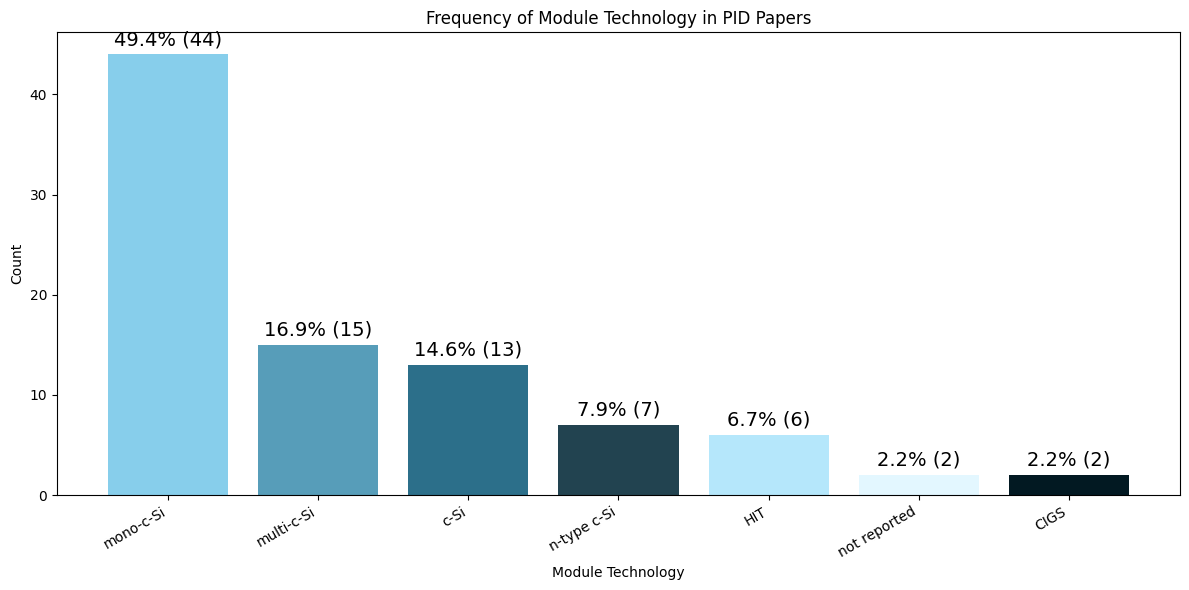

In [ ]:
import os
import json
from collections import Counter

import matplotlib.pyplot as plt

json_dir = "json_allPID"
module_techs = []

type_map = {
    "c-Si": "mono-c-Si",
    "n-type c-Si": "mono-c-Si",
}

# Collect all module technology entries from all JSON files
for fname in os.listdir(json_dir):
    if fname.endswith(".json"):
        with open(os.path.join(json_dir, fname), "r") as f:
            data = json.load(f)
            entries = data if isinstance(data, list) else [data]
            for entry in entries:
                techs = entry.get("module technology", "not reported")
                if isinstance(techs, list):
                    module_techs.extend(techs)
                else:
                    module_techs.append(techs)

# Count occurrences
counts = Counter(module_techs)
total = sum(counts.values())

# Sort by count descending
sorted_items = sorted(counts.items(), key=lambda x: x[1], reverse=True)
labels = [item[0] for item in sorted_items]
values = [item[1] for item in sorted_items]
percents = [100 * v / total for v in values]

plt.figure(figsize=(12, 6))
bars = plt.bar(labels, values, color=colors_mono)
plt.ylabel("Count")
plt.xlabel("Module Technology")
plt.title("Frequency of Module Technology in PID Papers")

# Annotate bars with percentage
for bar, percent, value in zip(bars, percents, values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
             f"{percent:.1f}% ({value})", ha='center', va='bottom', fontsize=14)

plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()

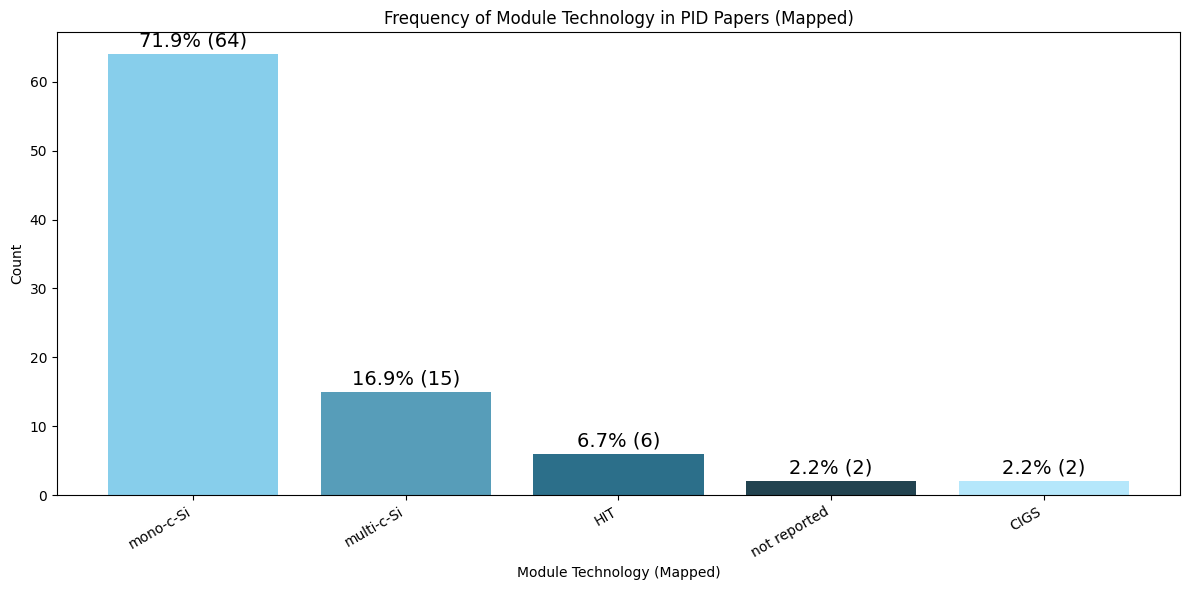

In [6]:
# Apply type_map to module_techs before counting
mapped_module_techs = [type_map.get(tech, tech) for tech in module_techs]
counts_mapped = Counter(mapped_module_techs)
total_mapped = sum(counts_mapped.values())

# Sort by count descending
sorted_items_mapped = sorted(counts_mapped.items(), key=lambda x: x[1], reverse=True)
labels_mapped = [item[0] for item in sorted_items_mapped]
values_mapped = [item[1] for item in sorted_items_mapped]
percents_mapped = [100 * v / total_mapped for v in values_mapped]

plt.figure(figsize=(12, 6))
bars = plt.bar(labels_mapped, values_mapped, color=colors_mono)
plt.ylabel("Count")
plt.xlabel("Module Technology (Mapped)")
plt.title("Frequency of Module Technology in PID Papers (Mapped)")

# Annotate bars with percentage
for bar, percent, value in zip(bars, percents_mapped, values_mapped):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
             f"{percent:.1f}% ({value})", ha='center', va='bottom', fontsize=14)

plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()

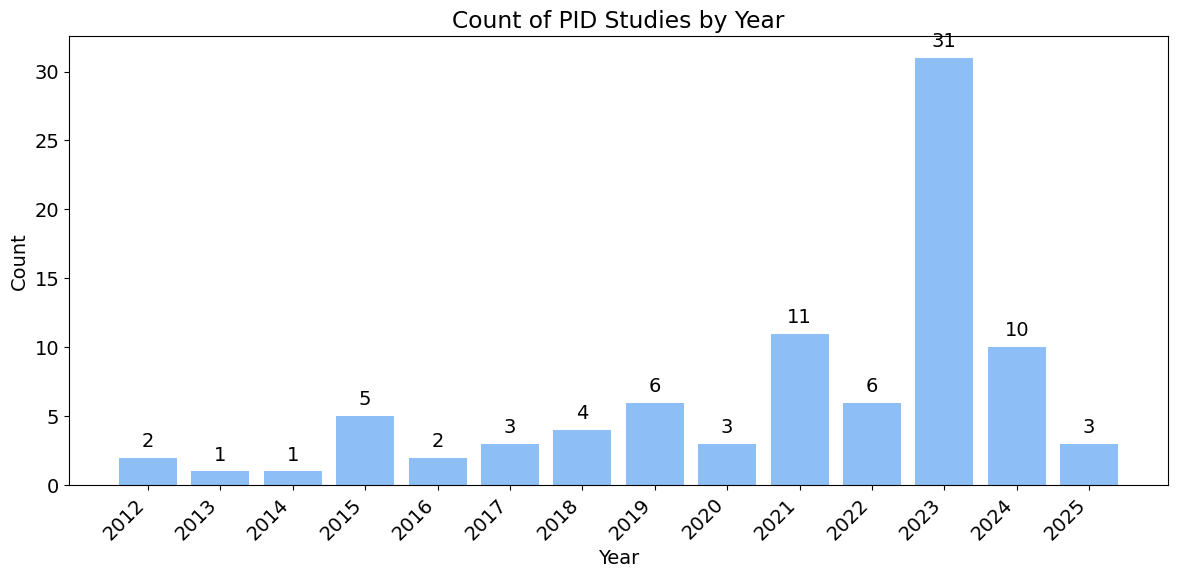

In [ ]:
import os
import json
from collections import Counter

import matplotlib.pyplot as plt

json_dir = "json_allPID"
year_counts = Counter()


# Collect year values from all JSON files
for fname in os.listdir(json_dir):
    if fname.endswith(".json"):
        with open(os.path.join(json_dir, fname), "r") as f:
            data = json.load(f)
            entries = data if isinstance(data, list) else [data]
            for entry in entries:
                year = entry.get("year", "not reported")
                year_counts[year] += 1

# Filter out "not reported" and sort years numerically
years = [y for y in year_counts if y != "not reported"]
years_sorted = sorted(years)
counts_sorted = [year_counts[y] for y in years_sorted]

plt.figure(figsize=(12, 6))
bars = plt.bar(years_sorted, counts_sorted, color="#8DBEF6")

# Annotate each bar with its count
for bar, count in zip(bars, counts_sorted):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
             str(count), ha='center', va='bottom', fontsize=14)

plt.xlabel("Year")
plt.ylabel("Count")
plt.title("Count of PID Studies by Year")
# Ensure all years between min and max are present
min_year = min(years_sorted)
max_year = max(years_sorted)
all_years = list(range(min_year, max_year + 1))
plt.xticks(all_years, rotation=45, ha='right')
plt.tight_layout()
plt.show()

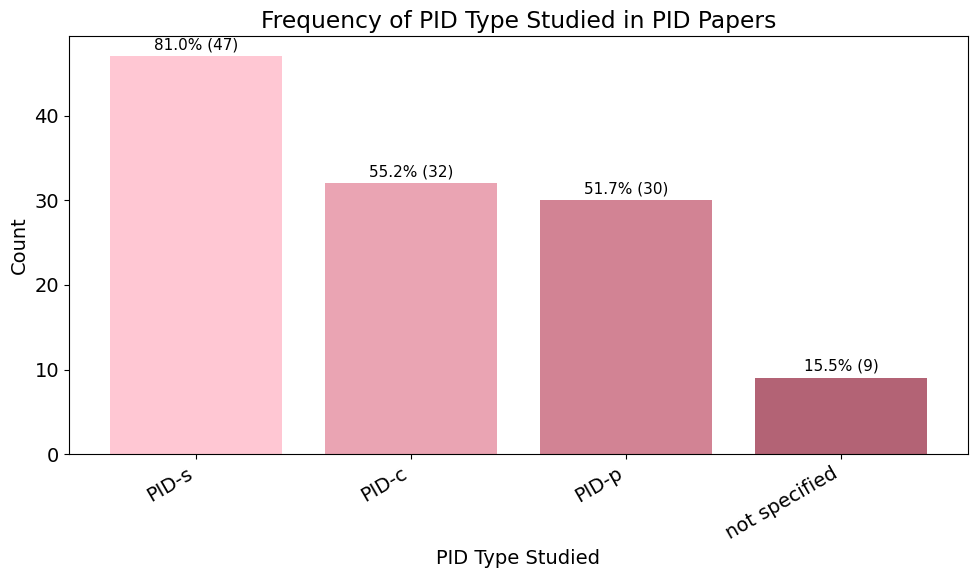

In [41]:
import os
import json
from collections import Counter

import matplotlib.pyplot as plt

json_dir = "json_allPID"
pid_types = []

# Mapping: treat "Na-penetration-type PID" as "PID-s"
type_map = {
    "Na-penetration-type PID": "PID-s"
}

# Collect PID type studied from all JSON files
for fname in os.listdir(json_dir):
    if fname.endswith(".json"):
        with open(os.path.join(json_dir, fname), "r") as f:
            data = json.load(f)
            entries = data if isinstance(data, list) else [data]
            for entry in entries:
                types = entry.get("PID type studied", [])
                if isinstance(types, str):
                    types = [types]
                for t in types:
                    mapped = type_map.get(t.strip(), t.strip())
                    pid_types.append(mapped)

# Count occurrences and sort by count descending
counts = Counter(pid_types)
sorted_items = sorted(counts.items(), key=lambda x: x[1], reverse=True)
labels = [item[0] for item in sorted_items]
values = [item[1] for item in sorted_items]
total_dicts = len([f for f in os.listdir(json_dir) if f.endswith(".json")])
percents = [100 * v / total_dicts for v in values]

plt.figure(figsize=(10, 6))
bars = plt.bar(labels, values, color=colors_mono2)
plt.ylabel("Count")
plt.xlabel("PID Type Studied")
plt.title("Frequency of PID Type Studied in PID Papers")

# Annotate bars with percentage and count
for bar, percent, value in zip(bars, percents, values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
             f"{percent:.1f}% ({value})", ha='center', va='bottom', fontsize=11)

plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()

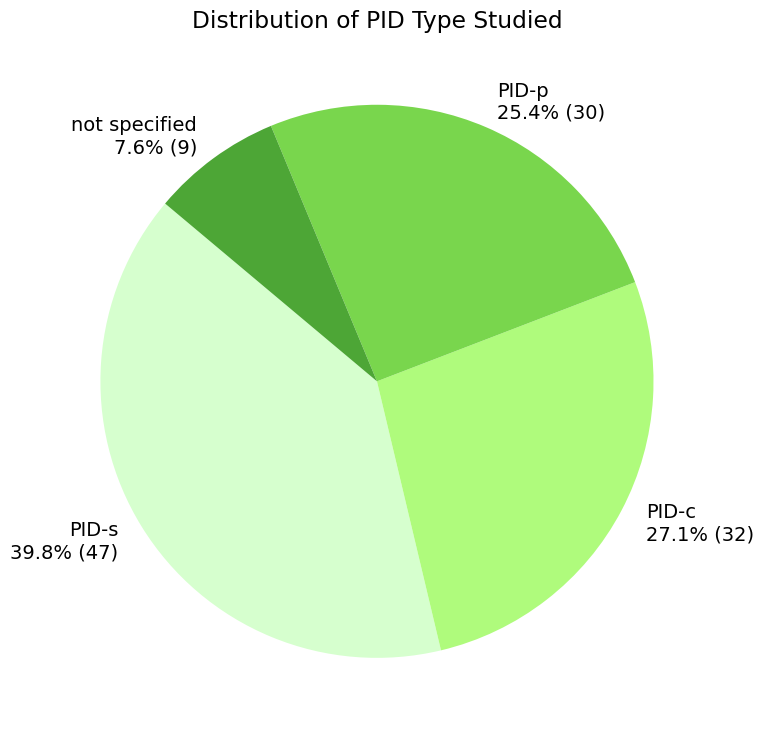

In [29]:
import os
import json
from collections import Counter
import matplotlib.pyplot as plt

json_dir = "json_allPID"
pid_types = []

# Mapping: rename specific PID types
type_map = {
    "Na-penetration-type PID": "PID-s"
}

for fname in os.listdir(json_dir):
    if fname.endswith(".json"):
        with open(os.path.join(json_dir, fname), "r") as f:
            data = json.load(f)
            # Handle both dict and list of dicts
            entries = data if isinstance(data, list) else [data]
            for entry in entries:
                types = entry.get("PID type studied", [])
                if isinstance(types, str):
                    types = [types]
                for t in types:
                    # Apply mapping if needed
                    mapped = type_map.get(t.strip(), t.strip())
                    pid_types.append(mapped)

counts = Counter(pid_types)
labels = []
sizes = []
total = sum(counts.values())
for pid, count in counts.items():
    percent = 100 * count / total
    labels.append(f"{pid}\n{percent:.1f}% ({count})")
    sizes.append(count)

plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct=None, startangle=140, colors=colors_mono4)
plt.title("Distribution of PID Type Studied")
plt.rcParams.update({'font.size': 14})
plt.tight_layout()
plt.show()


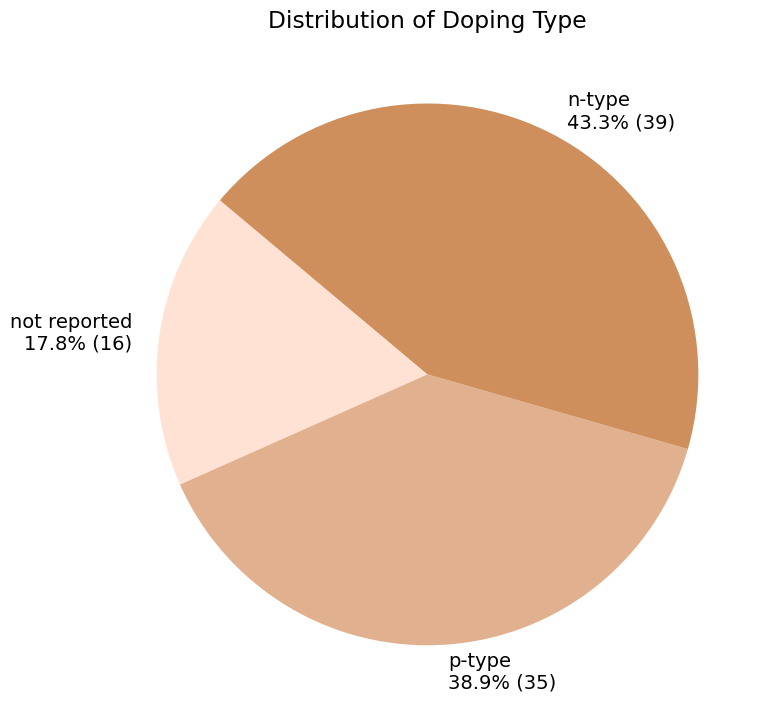

In [34]:
import os
import json
from collections import Counter

import matplotlib.pyplot as plt

json_dir = "json_allPID"
pid_types = []

for fname in os.listdir(json_dir):
    if fname.endswith(".json"):
        with open(os.path.join(json_dir, fname), "r") as f:
            data = json.load(f)
            # Handle both dict and list of dicts
            entries = data if isinstance(data, list) else [data]
            for entry in entries:
                types = entry.get("doping", [])
                if isinstance(types, str):
                    types = [types]
                pid_types.extend(types)

counts = Counter(pid_types)
labels = []
sizes = []
total = sum(counts.values())
for pid, count in counts.items():
    percent = 100 * count / total
    labels.append(f"{pid}\n{percent:.1f}% ({count})")
    sizes.append(count)

plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct=None, startangle=140, colors=colors_mono3)
plt.title("Distribution of Doping Type")
plt.rcParams.update({'font.size': 14})
plt.tight_layout()
plt.show()

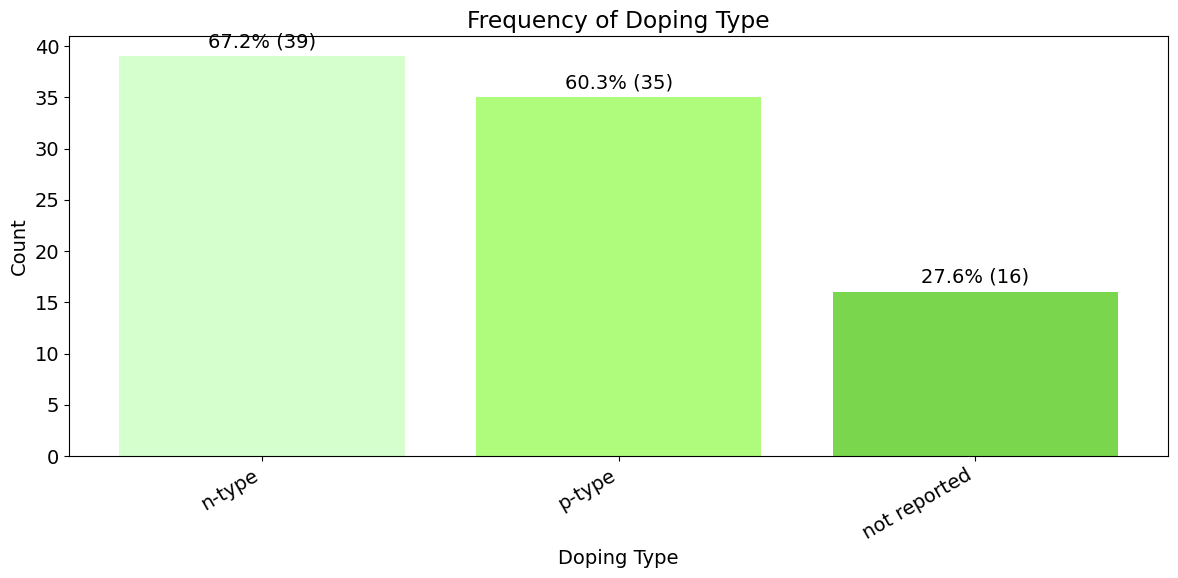

In [57]:
import os
import json
from collections import Counter

import matplotlib.pyplot as plt

json_dir = "json_allPID"
module_techs = []

# Collect all module technology entries from all JSON files
for fname in os.listdir(json_dir):
    if fname.endswith(".json"):
        with open(os.path.join(json_dir, fname), "r") as f:
            data = json.load(f)
            entries = data if isinstance(data, list) else [data]
            for entry in entries:
                techs = entry.get("doping", "not reported")
                if isinstance(techs, list):
                    module_techs.extend(techs)
                else:
                    module_techs.append(techs)

# Count occurrences
counts = Counter(module_techs)
total = sum(counts.values())

# Sort by count descending
sorted_items = sorted(counts.items(), key=lambda x: x[1], reverse=True)
labels = [item[0] for item in sorted_items]
values = [item[1] for item in sorted_items]
percents = [100 * v / total_dicts for v in values]

plt.figure(figsize=(12, 6))
bars = plt.bar(labels, values, color=colors_mono4)
plt.ylabel("Count")
plt.xlabel("Doping Type")
plt.title("Frequency of Doping Type")

# Annotate bars with percentage
for bar, percent, value in zip(bars, percents, values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
             f"{percent:.1f}% ({value})", ha='center', va='bottom', fontsize=14)

plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()

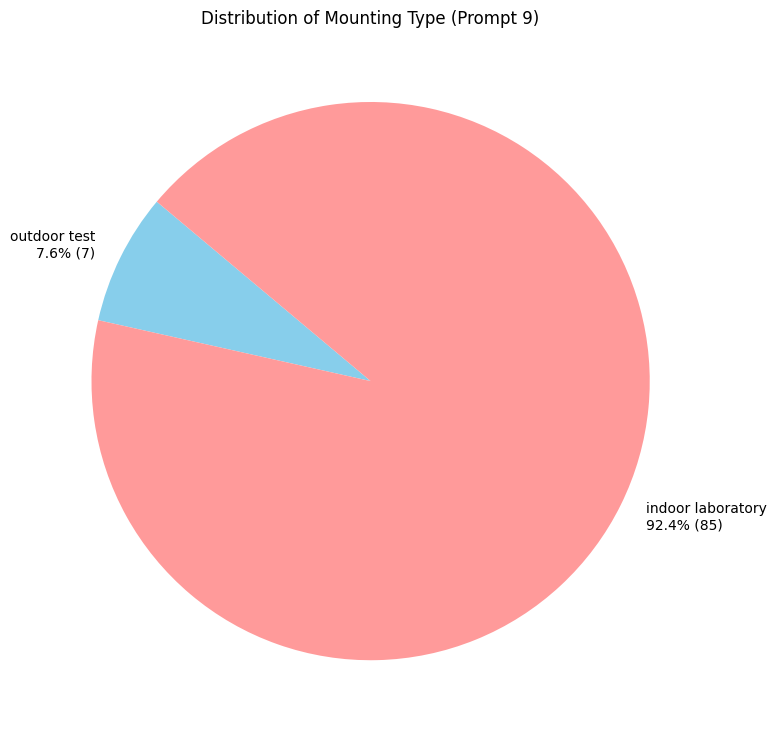

In [ ]:
json_dir = "json_allPID"
pid_types = []

for fname in os.listdir(json_dir):
    if fname.endswith(".json"):
        with open(os.path.join(json_dir, fname), "r") as f:
            data = json.load(f)
            # Handle both dict and list of dicts
            entries = data if isinstance(data, list) else [data]
            for entry in entries:
                types = entry.get("mounting", [])
                if isinstance(types, str):
                    types = [types]
                pid_types.extend(types)
# Build mapped & normalized list as before
category_map = {
    "roof": "outdoor test",
    "rack": "outdoor test"
}
normalized_types = []
for t in pid_types:
    t_clean = t.lower().strip()
    mapped = category_map.get(t_clean, t_clean)
    normalized_types.append(mapped)

counts = Counter(normalized_types)
labels = []
sizes = []
total = sum(counts.values())
for pid, count in counts.items():
    percent = 100 * count / total
    labels.append(f"{pid}\n{percent:.1f}% ({count})")
    sizes.append(count)
    labeldistance=1.5

plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct=None, startangle=140, colors=colors)
plt.title("Distribution of Mounting Type (Prompt 9)")
plt.tight_layout()
plt.show()

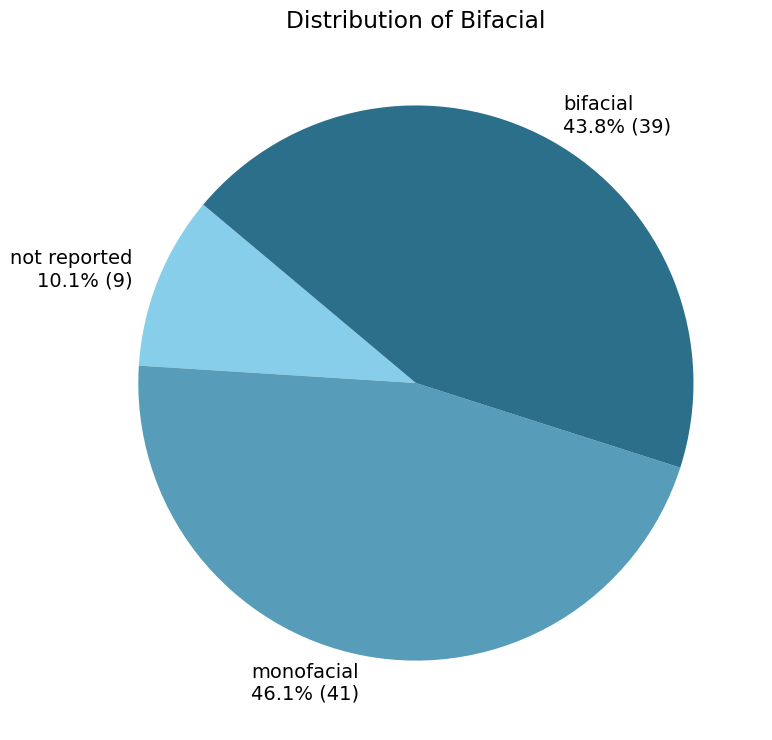

In [32]:
json_dir = "json_allPID"
pid_types = []

for fname in os.listdir(json_dir):
    if fname.endswith(".json"):
        with open(os.path.join(json_dir, fname), "r") as f:
            data = json.load(f)
            # Handle both dict and list of dicts
            entries = data if isinstance(data, list) else [data]
            for entry in entries:
                types = entry.get("bifacial", [])
                if isinstance(types, str):
                    types = [types]
                pid_types.extend(types)

counts = Counter(pid_types)
labels = []
sizes = []
total = sum(counts.values())
for pid, count in counts.items():
    percent = 100 * count / total
    labels.append(f"{pid}\n{percent:.1f}% ({count})")
    sizes.append(count)

plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct=None, startangle=140, colors=colors_mono)
plt.title("Distribution of Bifacial")
plt.rcParams.update({'font.size': 14})
plt.tight_layout()
plt.show()

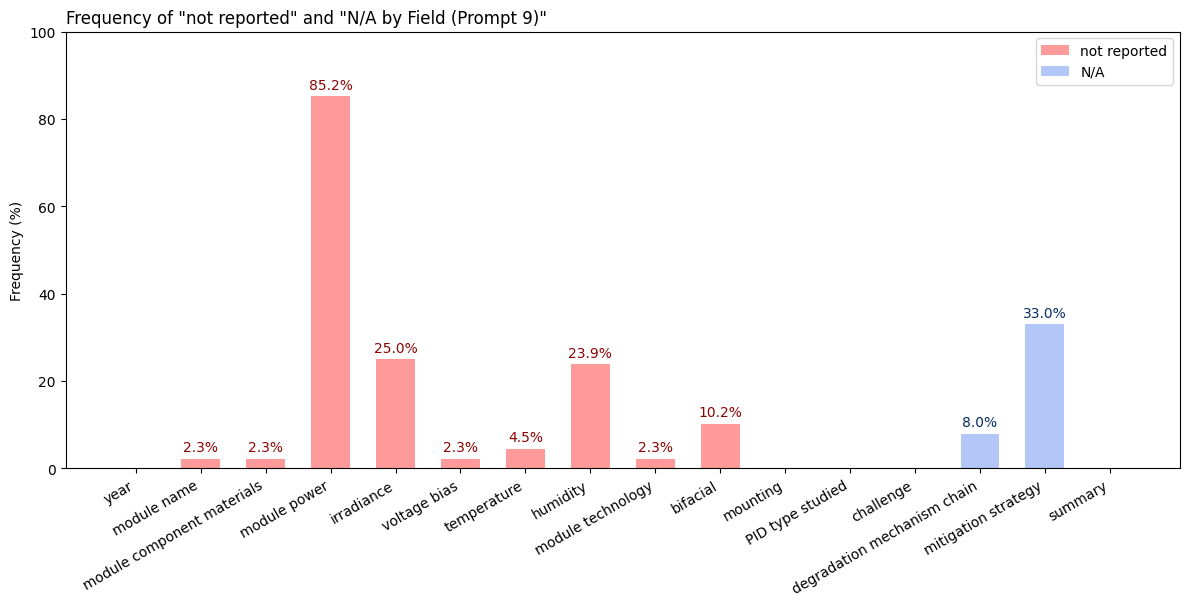

In [51]:
import os
import json
import numpy as np

import matplotlib.pyplot as plt

json_dir = "json_allPID"
fields = [
    "year",
    "module name",
    "module component materials",
    "module power",
    "irradiance",
    "voltage bias",
    "temperature",
    "humidity",
    "module technology",
    "bifacial",
    "mounting",
    "PID type studied",
    "challenge",
    "degradation mechanism chain",
    "mitigation strategy",
    "summary"
]

not_reported_counts = {field: 0 for field in fields}
na_counts = {field: 0 for field in fields}
total_entries = 0

for fname in os.listdir(json_dir):
    if fname.endswith(".json"):
        with open(os.path.join(json_dir, fname), "r") as f:
            data = json.load(f)
            entries = data if isinstance(data, list) else [data]
            for entry in entries:
                total_entries += 1
                for field in fields:
                    value = entry.get(field, "not reported")
                    # For lists, check if any element is "not reported" or "N/A"
                    if isinstance(value, list):
                        if any(str(v).strip().lower() == "not reported" for v in value):
                            not_reported_counts[field] += 1
                        if any(str(v).strip().upper() == "N/A" for v in value):
                            na_counts[field] += 1
                    else:
                        if str(value).strip().lower() == "not reported":
                            not_reported_counts[field] += 1
                        if str(value).strip().upper() == "N/A":
                            na_counts[field] += 1

# Calculate percentages
not_reported_perc = [100 * not_reported_counts[field] / total_entries for field in fields]
na_perc = [100 * na_counts[field] / total_entries for field in fields]

x = np.arange(len(fields))
width = 0.6
fig, ax = plt.subplots(figsize=(12, 6))
bar1 = ax.bar(x, not_reported_perc, width, label='not reported', color='#FF9A9A')
bar2 = ax.bar(x, na_perc, width, bottom=not_reported_perc, label='N/A', color="#B2C6F7")

ax.set_ylabel('Frequency (%)')
ax.set_xticks(x)
ax.set_xticklabels(fields, rotation=30, ha='right')
ax.set_ylim(0, 100)
ax.legend(loc='upper right')
plt.tight_layout()

# Annotate not_reported_perc
for i, v in enumerate(not_reported_perc):
    if v > 0:
        ax.text(i, v + 1, f"{v:.1f}%", ha='center', va='bottom', fontsize=10, color="#8C0404")

# Annotate na_perc (stacked on top)
for i, (v1, v2) in enumerate(zip(not_reported_perc, na_perc)):
    if v2 > 0:
        ax.text(i, v1 + v2 + 1, f"{v2:.1f}%", ha='center', va='bottom', fontsize=10, color="#052D64")
ax.set_title('Frequency of "not reported" and "N/A by Field (Prompt 9)"', loc='left')
plt.show()